# Short Course: Machine Learning for Exploration Geophysics

Hamburg, 10. - 12. March 2020

#### Computer Class 1.2: Nonlinear Regression

Table of Content:
- [Packages](#Packages)
- [Import and preprocess the dataset](#Import-and-preprocess-the-dataset)
- [Polynomial Regression](#Polynomial-Regression)
- [Make pipeline](#Make-pipeline)
- [Visualize the results](#Visualize-the-results)
- [Regression with regularizer](#Regression-with-regularizer)
- [Cross Validation](#Cross-Validation)

## Packages

Let's first import all the packages: 
- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python.
- [pandas](https://pandas.pydata.org/) is a software library for data manipulation and analysis.
- [matplotlib](https://matplotlib.org/) is a comprehensive library for creating static, animated, and interactive visualizations in Python.
- [seaborn](https://seaborn.pydata.org/) is a statistical data visualization library based on matplotlib.
- [scikit-learn](https://scikit-learn.org/stable/) is a simple and efficient tools for predictive data analysis.

In [1]:
#!pip install pandas
#!pip install -U scikit-learn

#!python -m pip install -U pip
#!python -m pip install -U matplotlib

#!pip install pandas

#!pip install seaborn

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV

import warnings
warnings.filterwarnings('ignore')

print('Pandas:  ' + pd.__version__)
print('Numpy:   ' + np.__version__)
print('Sklearn: ' + sklearn.__version__)

Pandas:  0.24.2
Numpy:   1.17.4
Sklearn: 0.22.2.post1


## Import and preprocess the dataset

In [3]:
df = pd.read_csv('data/berlin_flat_price.csv')
df['Price'] = df['Price']/1000;  # in 1000s euro

X = df[['Size']].values
y = df['Price'].values    

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

#X_scaled.mean()
#X_scaled.std()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle=False)

## Polynomial Regression

#### Polynomial features
Idea: Generate a new feature matrix $X$ consisting of all polynomial combinations of the features with degree less than or equal to the specified 'degree'. 

Example: if an input sample is two dimensional and of the form $[a, b]$, the degree-2 polynomial features are $[1, a, b, a^2, ab, b^2]$.

Use function [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) to generate polynomial and interaction features:

In [4]:
print(X_train.shape)

degree = 4
poly = PolynomialFeatures(degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

print(X_train_poly.shape)

(124, 1)
(124, 5)


#### Linear Regression

In [5]:
Lreg = LinearRegression()
# train
Lreg.fit(X_train, y_train)
# predict
y_pred = Lreg.predict(X_test)

# results:
print('Linear Regression score: ' + str(Lreg.score(X_train,y_train)))
print('Linear Regression RMSE: ' + str(mean_squared_error(y_test, y_pred, squared=False)))
print('Parameter b: ' + str(Lreg.intercept_))
print('Parameter w: ' + str(Lreg.coef_))

Linear Regression score: 0.8257816688788631
Linear Regression RMSE: 96.53505606589923
Parameter b: -54.5158939192508
Parameter w: [5.57343474]


#### Polynomial Regression

In [6]:
Preg = LinearRegression(fit_intercept=False)
# train
Preg.fit(X_train_poly, y_train)
# predict
y_pred = Preg.predict(X_test_poly)

# results:
print('Polynomial Regression score: ' + str(Preg.score(X_train_poly,y_train)))
print('Polynomial Regression RMSE: ' + str(mean_squared_error(y_test, y_pred, squared=False)))
print('Parameter b: ' + str(Preg.intercept_))
print('Parameter w: ' + str(Preg.coef_))

Polynomial Regression score: 0.8556569317645617
Polynomial Regression RMSE: 96.0883655018257
Parameter b: 0.0
Parameter w: [-1.28429179e+02  1.75652385e+01 -3.71234553e-01  3.87388312e-03
 -1.28228443e-05]


## Make pipeline

It is convenient to combine several steps in the pipeline:

- Example 1: PolynomialFeatures(degree) -> LinearRegression()
- Example 2: StandardScaler() -> PolynomialFeatures(degree) -> LinearRegression()

Use [make_pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) for that!



In [7]:
poly_reg = make_pipeline(StandardScaler(),PolynomialFeatures(degree=4), LinearRegression())
poly_reg.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('polynomialfeatures',
                 PolynomialFeatures(degree=4, include_bias=True,
                                    interaction_only=False, order='C')),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

## Visualize the results

Polynomial Regression degree 1:   Train RMSE: 72.39    Test RMSE: 96.54
Polynomial Regression degree 2:   Train RMSE: 68.47    Test RMSE: 91.38
Polynomial Regression degree 3:   Train RMSE: 67.09    Test RMSE: 94.21
Polynomial Regression degree 4:   Train RMSE: 65.89    Test RMSE: 96.09
Polynomial Regression degree 5:   Train RMSE: 64.59    Test RMSE: 98.94


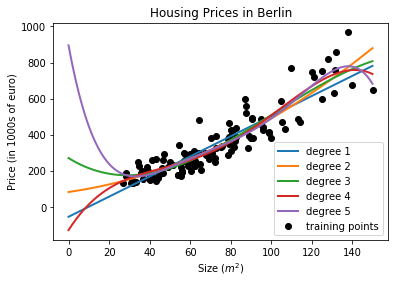

In [8]:
X_plot = np.linspace(0,150,150)
X_plot = np.matrix(X_plot).T

fig = plt.figure()
plt.scatter(X_train, y_train, color='black', marker='o', label="training points")
for count, degree in enumerate([1, 2, 3, 4, 5]):
    poly_reg = make_pipeline(StandardScaler(),PolynomialFeatures(degree), LinearRegression(fit_intercept=False))
    poly_reg.fit(X_train, y_train)
    y_plot = poly_reg.predict(X_plot)
    plt.plot(X_plot, y_plot, linewidth=2, label="degree %d" % degree)
    print('Polynomial Regression degree %d:' % degree 
          + '   Train RMSE: ' + '%.2f' % mean_squared_error(y_train, poly_reg.predict(X_train), squared=False)
          + '    Test RMSE: ' + '%.2f' % mean_squared_error(y_test, poly_reg.predict(X_test), squared=False))

plt.xlabel('Size ($m^2$)')
plt.ylabel('Price (in 1000s of euro)')
plt.title('Housing Prices in Berlin')
plt.legend(loc='lower right')
plt.show()
fig.tight_layout()
fig.savefig("CC1_2_Figure_Polynomial_regression.png", dpi=300)

## Regression with regularization

- [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge)
- [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso)
- [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet)    
    
#### Ridge

Linear least squares with $L_2$ regularization. Minimizes the objective function:

$$J = \frac{1}{2N} |y - Xw|^2_2 + \alpha \sum_i w_i^2$$


#### Lasso

Linear Model trained with $L_1$ regularization. The optimization objective for Lasso is:
 
$$J = \frac{1}{2N} |y - Xw|^2_2 + \alpha \sum_i |w|$$


#### ElasticNet

Linear regression with combined $L_1$ and $L_2$ priors as regularizer. Minimizes the objective function:

$$J = \frac{1}{2N} |y - Xw|^2_2 + \alpha \gamma \sum_i |w| +  \alpha  (1 - \gamma) \frac{1}{2}\sum_i w_i^2$$

- $ \gamma = 1$: ElasticNet -> Lasso
- $ \gamma = 0$: ElasticNet -> Ridge










In [9]:
poly_reg = make_pipeline(StandardScaler(), PolynomialFeatures(degree=2), Ridge(alpha=1, fit_intercept=False))
poly_reg.fit(X_train, y_train)

print('Polynomial Regression degree %d with L2 regularization:' % 2
    + '   Train RMSE: ' + '%.2f' % mean_squared_error(y_train, poly_reg.predict(X_train), squared=False)
    + '    Test RMSE: ' + '%.2f' % mean_squared_error(y_test, poly_reg.predict(X_test), squared=False))


Polynomial Regression degree 2 with L2 regularization:   Train RMSE: 68.58    Test RMSE: 88.90


## Cross Validation

[RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV) function combines Ridge and Cross Validation:

In [10]:
test_alphas = np.array([0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32])

poly_reg_CV = make_pipeline(StandardScaler(), PolynomialFeatures(degree=2), 
                            RidgeCV(alphas=test_alphas, fit_intercept=False, cv=5))
poly_reg_CV.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridgecv',
                 RidgeCV(alphas=array([ 0.0625,  0.125 ,  0.25  ,  0.5   ,  1.    ,  2.    ,  4.    ,
        8.    , 16.    , 32.    ]),
                         cv=5, fit_intercept=False, gcv_mode=None,
                         normalize=False, scoring=None,
                         store_cv_values=False))],
         verbose=False)

In [11]:
print('Polynomial Regression degree %d with L2 regularization and CV:' % 2
    + '   Train RMSE: ' + '%.2f' % mean_squared_error(y_train, poly_reg_CV.predict(X_train), squared=False)
    + '    Test RMSE: ' + '%.2f' % mean_squared_error(y_test, poly_reg_CV.predict(X_test), squared=False))

Polynomial Regression degree 2 with L2 regularization and CV:   Train RMSE: 69.99    Test RMSE: 82.41
